## Working with custom resnet
https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54

Original

In [1]:
import cv2
import numpy as np
import tensorflow as tf

IMAGE_PATH = './cat.jpg'
LAYER_NAME = 'block5_conv3'
CAT_CLASS_INDEX = 281

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAT_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

cv2.imwrite('cam.png', output_image)

True

Fixed to custom ResNet

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

IMAGE_PATH = './cat.jpg'
LAYER_NAME = 'conv5_block3_3_conv'
CAT_CLASS_INDEX = 22

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)



def build_model(output_size, input_shape=(224, 224, 3), final_activation="softmax"):

    base_model = ResNet50(
        input_shape=input_shape,
        weights="imagenet",
        include_top=False
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    output = Dense(output_size, activation=final_activation)(x)
    
    return Model(outputs=output, inputs=base_model.input)




model = build_model(output_size = 23)


grad_model = tf.keras.models.Model([model.inputs], [model.get_layer("conv5_block3_3_conv").output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAT_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

cv2.imwrite('cam.png', output_image)

Tried something but it didnt work

In [1]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model

from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras import models

import tensorflow as tf
import numpy as np

In [2]:
image_size = 224

# Load pre-trained Keras model and the image to classify
model = tf.keras.applications.vgg16.VGG16()
image = np.random.random((image_size, image_size, 3))
img_tensor = preprocessing.image.img_to_array(image)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

conv_layer = model.get_layer("block5_conv3")
heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

# Get gradient of the winner class w.r.t. the output of the (last) conv. layer
with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img_tensor)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat

print(heatmap.shape)

553467904/553467096 [==============================] - 21s 0us/step
(1, 14, 14)


(-0.5, 13.5, 13.5, -0.5)

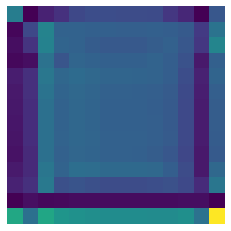

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(heatmap[-1])
plt.axis("off")

https://github.com/gabrieldemarmiesse/heatmaps

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras import backend as K

from heatmap import to_heatmap, synset_to_dfs_ids


def display_heatmap(new_model, img_path, ids, preprocessing=None):
    # The quality is reduced.
    # If you have more than 8GB of RAM, you can try to increase it.
    img = image.load_img(img_path, target_size=(800, 1280))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    if preprocessing is not None:
        x = preprocess_input(x)

    out = new_model.predict(x)

    heatmap = out[0]  # Removing batch axis.

    if K.image_data_format() == 'channels_first':
        heatmap = heatmap[ids]
        if heatmap.ndim == 3:
            heatmap = np.sum(heatmap, axis=0)
    else:
        heatmap = heatmap[:, :, ids]
        if heatmap.ndim == 3:
            heatmap = np.sum(heatmap, axis=2)

    plt.imshow(heatmap, interpolation="none")
    plt.show()

Using TensorFlow backend.


FileNotFoundError: [Errno 2] No such file or directory: '/home/henrik/master_thesis/code/testing/data/meta_clsloc.mat'